In [2]:
%pwd

'c:\\Users\\p.peng\\OneDrive - Impax Asset Management Group plc\\Documents\\7_JapanExpertGroup'

In [179]:
from xbbg import blp
import requests
from urllib.parse import urljoin
from urllib3 import Retry
from requests.adapters import HTTPAdapter
import pandas as pd
import numpy as np
import json
import datetime as dt
import seaborn as sns 
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
from typing import Union, Optional

LINKS = ['https://www.jpx.co.jp/english/listing/stocks/new/index.html'] +\
    [f'https://www.jpx.co.jp/english/listing/stocks/new/00-archives-0{i}.html' for i in range(0, 5)]

class JPX:
    def __init__(self, config_path: str="./config/config.json"):
        self.config_path = config_path
        if config_path:
            self.headers = json.load(open(config_path, "r"))
        else:
            self.headers = dict()
        self.session = requests.Session()
        adapter = HTTPAdapter(max_retries=Retry(total=3, connect=3, read=2, redirect=3))
        self.session.mount("https://", adapter=adapter)
        self.links = LINKS
        self.endpoint = 'https://www2.jpx.co.jp/tseHpFront/JJK020010Action.do'
        self.option_dict = {'Standard': '012',
                            'Growth': '013',
                            'TOKYO PRO Market': '008',
                            '－': 'be2',
                            'Prime Foreign Stocks': '111',
                            'Standard Foreign Stocks': '112',
                            'Growth Foreign Stocks': '113',
                            'ETFs': 'ETF',
                            'ETNs': 'ETN',
                            'Real Estate Investment Trusts (REITs)': 'RET',
                            'Infrastructure Funds': 'IFD',
                            'Others': '999'}
        self.option_names = dict(show_list='ListShow', entries_per_page='dspSsuPd', market_section='szkbuChkbx',page='lstDspPg')
    def getStockList(self, **kwargs):
        """
        :param **kwargs: takes the following & defaults 
            show_list: 'ListShow'
            entries_per_page: 200 (number of entries per page)
            market_section: None
        """
        data = {"sniMtGmnId": '',
                "dspSsuPdMapOut": "10>10<50>50<100>100<200>200<",
                "mgrMiTxtBx": '',
                "eqMgrCd": '',
                "szkbuChkbxMapOut": "011>Prime<012>Standard<013>Growth<008>TOKYO PRO Market<bj1>－<be1>－<111>Prime Foreign Stocks<112>Standard Foreign Stocks<113>Growth Foreign Stocks<bj2>－<be2>－<ETF>ETFs<ETN>ETNs<RET>Real Estate Investment Trusts (REITs)<IFD>Infrastructure Funds<999>Others<",
                }
        data.update({self.option_names.get(k): v for k, v in kwargs.items()})
        if 'market_section' in kwargs.keys(): 
            data.update({self.option_names.get('market_section'): self.option_dict.get(kwargs.get('market_section'))})
        ls = []
        nextPageExists = True
        page = 1
        while nextPageExists:
            data.update({'lstDspPg': str(int(page))})
            res = self.session.post(f"{self.endpoint};{self.headers.get('Cookie').split(': ')[0]}", data=data, headers=self.headers)
            ls.append(pd.read_html(res.text)[0])
            s = bs(res.text, 'lxml')
            nextPageExists = len(s.find_all("div", {"class": "next_e"})) > 0
            page += 1

        return pd.concat(ls)
        
    
    def run(self):
        ls = []
        for link in self.links:
            try:
                res = self.session.get(link, headers=self.headers)
                ls.append(pd.read_html(res.text)[0])
            except ValueError as e:
                print(f"error = {e}")
                pass
            except Exception as e:
                print(f"error = {e}")
                pass
        df = pd.concat(ls)
        return df

In [345]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import asyncio 
import nest_asyncio
nest_asyncio.apply()

class sectionAnalysis:
    @staticmethod
    def to_sql(df, table_name, engine, if_exists='replace', index=True):
        df.to_sql(table_name, engine, if_exists=if_exists, index=index)
    
    @staticmethod
    def get_desc(tickers, **kwargs):
        desc = blp.bdp(tickers, ['short_name', 'gics_industry_name', 'gics_sub_industry_name',
        'gocs_sectorname', 'eqy_init_po_dt', 'eqy_init_po_sh_px', 'cie_des'])
        return desc, "desc"
    
    @staticmethod
    def get_market_data(tickers, start_date, end_date, **kwargs):
        market_data = blp.bdh(tickers, 
            flds=['px_last', 'pe_ratio', 'px_to_sales_ratio', 'ev_ebitda', 'px_to_book_ratio'], 
            start_date=start_date, 
            end_date=end_date)
        market_data = market_data.swaplevel(i=0, j=1, axis=1).T.sort_index().T
        market_data.index.names = ['date']
        market_data.columns.names = ['field', 'ticker']
        return market_data, "market_data"
    
    @staticmethod
    def get_fundamental_data(tickers, start_date, end_date, **kwargs):
        fundamental_data = blp.bdh(tickers, start_date=start_date, 
            end_date=end_date, flds=['sales_rev_turn', 'ebitda_margin', 'cur_mkt_cap',
            'trailing_12m_sales_growth', 'sales_3yr_avg_growth', 'sales_5yr_avg_growth', 
            'gross_margin', 'ebit_margin', 'operating_cash_flow_margin'], Per='Y')
        fundamental_data.index = pd.MultiIndex.from_tuples([(d.year, d.month, d.day) 
            for d in fundamental_data.index])
        fundamental_data.index.names = ['year', 'month', 'day']
        fundamental_data = fundamental_data.groupby(by="year", axis=0).mean()
        return fundamental_data.T, "fundamental_data"

    def __init__(self, tickers: Union[list, pd.Series], 
        db_name: str, data_dir:str,  
        start_date: dt.date=dt.date(1997, 1, 1), end_date: dt.date=dt.date.today(),
        max_workers=1):
        self.db_path = os.path.join(data_dir, db_name)
        self.sql_conn = sqlite3.connect(self.db_path, check_same_thread=False)
        self.curr = self.sql_conn.cursor()
        self.tickers = tickers
        
        if max_workers > 1:

            with ThreadPoolExecutor(max_workers=max_workers) as executor:
                futures = [executor.submit(self.get_desc, tickers),
                    executor.submit(self.get_market_data, tickers, start_date, end_date),
                    executor.submit(self.get_fundamental_data, tickers, start_date, end_date)]

                for future in as_completed(futures):
                    df, name = future.result()
                    self.to_sql(df, name, self.sql_conn)
        else:
            def get_data_to_sql(field, **kwargs):
                df, name = eval(f"self.get_{field}(tickers, **kwargs)")
                print(name)
                self.to_sql(df, name, self.sql_conn)
                print("done")
            for field in ['desc', 'market_data', 'fundamental_data']:
                if field == 'desc':
                    get_data_to_sql(field)
                else:
                    get_data_to_sql(field, start_date=start_date, end_date=end_date)
    def close(self):
        self.sql_conn.close()


    

In [344]:
sectionAnalysis.get_fundamental_data(japan_indices.tickers, dt.date(2021,1,1), dt.date.today())

(year                                  2021
 nky index      ebitda_margin  1.680000e+01
                cur_mkt_cap    4.699875e+08
                gross_margin   3.118000e+01
 tsemothr index ebitda_margin  4.110000e+00
                cur_mkt_cap    8.238815e+06
                gross_margin   4.252000e+01
 tpx index      ebitda_margin  1.253000e+01
                cur_mkt_cap    7.352347e+08
                gross_margin   2.612000e+01,
 'fundamental_data')

In [346]:
jasdaq = blp.bds('jsda index', 'indx_members').member_ticker_and_exchange_code.apply(lambda x: f"{x} Equity").unique()
jasdaq = sectionAnalysis(jasdaq, "jasdaq.db", "sqldata", max_workers=1)

desc
done
market_data
done
fundamental_data
done


In [347]:
japan_indices = ['jasdaq index', 'nky index', 'gjgb10 index', 'jpyusd curncy', 
    'tsemothr index', 'tpx index', ]
japan_indices = sectionAnalysis(japan_indices, "japan_indices.db", "sqldata", max_workers=1)

desc
done


In [73]:
jpx = JPX()
growth_board_stocks = jpx.getStockList(show_list='ListShow', entries_per_page='200', market_section='Growth')
tickers = growth_board_stocks.Code.dropna().astype(str).apply(lambda x: f"{x[:4]} JP Equity")
desc = blp.bdp(tickers, ['short_name', 'gics_industry_name', 'eqy_init_po_dt', 'eqy_init_po_sh_px', ''])
data = blp.bdh(tickers, 
    flds=['px_last', 'pe_ratio', 'px_to_sales_ratio', 'ev_ebitda', 'px_to_book_ratio'], 
    start_date=dt.date(1997, 1, 1), 
    end_date=dt.date.today())
data = data.swaplevel(i=0, j=1, axis=1).T.sort_index().T
data.index.names = ['date']
data.columns.names = ['field', 'ticker']

In [74]:
# save data to sql
import sqlite3
import os

root = os.getcwd()
db_path = os.path.join(root, 'sqldata', 'jpx_growth.db')
sql_conn = sqlite3.connect(db_path, check_same_thread=False)
curr = sql_conn.cursor()
data.to_sql("price_data", sql_conn, if_exists='replace')

# modify desc and save
growth_board_stocks.Code = tickers.values
desc = desc.dropna()
desc.index.names = ['ticker']
desc = desc.merge(growth_board_stocks, left_on='ticker', right_on='Code')
desc.to_sql("desc_data", sql_conn, if_exists='replace')

455

In [242]:
fundamental_data = blp.bdh(tickers, start_date=dt.date(1997, 1, 1), 
    end_date=dt.date.today(), flds=['sales_rev_turn', 'ebitda_margin', 'cur_mkt_cap',
    'trailing_12m_sales_growth', 'sales_3yr_avg_growth', 'sales_5yr_avg_growth', 
    'gross_margin', 'ebit_margin', 'operating_cash_flow_margin'], Per='Y')
fundamental_data.index = pd.MultiIndex.from_tuples([(d.year, d.month, d.day) for d in fundamental_data.index])
fundamental_data.index.names = ['year', 'month', 'day']
fundamental_data = fundamental_data.groupby(by="year", axis=0).mean()
fundamental_data.T.to_sql("fundamental_data", sql_conn, if_exists='replace')

3269

In [184]:
# get start date
def standardize_by_start(desc: pd.DataFrame=desc, 
    data: pd.DataFrame=data, field: str='pe_ratio', listing_year: Union[list[int], None]=None):
    if listing_year:
        desc = desc.loc[desc.eqy_init_po_dt.apply(lambda d: d.year).isin(listing_year).values, :]
    if len(desc):
        start_dates = dict(desc.loc[:, ['Code', 'eqy_init_po_dt']].values)
        ls = []
        for ticker, s in data.loc[:, field].iteritems():
            if isinstance(start_dates.get(ticker), dt.date):
                temp = s.loc[start_dates.get(ticker):].dropna()
                temp.index = range(len(temp))
                temp.name = ticker
                ls.append(temp.to_frame())
        return start_dates, pd.concat([i.T for i in ls]).T

In [80]:
desc.gics_industry_name.unique()

array(['Construction & Engineering', 'Household Durables',
       'Real Estate Management & Devel', 'Independent Power and Renewabl',
       'Health Care Technology', 'IT Services', 'Biotechnology', 'Media',
       'Software', 'Interactive Media & Services',
       'Life Sciences Tools & Services', 'Personal Products',
       'Consumer Finance', 'Entertainment',
       'Commercial Services & Supplies', 'Professional Services',
       'Food & Staples Retailing', 'Internet & Direct Marketing Re',
       'Hotels, Restaurants & Leisure', 'Textiles, Apparel & Luxury Goo',
       'Distributors', 'Containers & Packaging', 'Specialty Retail',
       'Semiconductors & Semiconductor', 'Electronic Equipment, Instrume',
       'Communications Equipment', 'Capital Markets',
       'Diversified Consumer Services', 'Diversified Telecommunication',
       'Wireless Telecommunication Ser', 'Pharmaceuticals',
       'Health Care Providers & Servic', 'Machinery', 'Chemicals',
       'Technology Hardware,

In [76]:
pe_since_ipo = standardize_by_start()[1]
ps_since_ipo = standardize_by_start(field='px_to_sales_ratio')[1]
px_since_ipo = standardize_by_start(field='px_to_sales_ratio')[1]

In [194]:
def get_change_since_ipo(desc=desc, field='pe_ratio', sector='Electronic Equipment, Instrume', listing_year=None):
    """
    :param field: bbg field to be passed to standardize_by_start(), 
    :param sector: if pass 'all', will not be filtered"""
    if sector == 'all': tickers = desc.Code
    else: tickers = desc.loc[desc.gics_industry_name == sector, 'Code'].values
    data = standardize_by_start(field=field, listing_year=listing_year)[1]
    tickers = data.columns.intersection(tickers)
    data = data.loc[:, tickers]
    if field != 'px_last': return data - data.iloc[0, :]
    else: 
        ipo_px = dict(desc.loc[:, ['Code', 'eqy_init_po_sh_px']].values)
        return data / data.columns.to_series().map(ipo_px).values

In [201]:
def plot_change_since_ipo(field='pe_ratio', sector='Electronic Equipment, Instrume',
    figsize=(10, 6), xlim=(1, 365), ylim=(-50, 50), listing_year=None):
    data = get_change_since_ipo(field=field, sector=sector, listing_year=listing_year)
    n = data.shape[1]
    f, ax = plt.subplots(1, figsize=figsize)
    mean = data.mean(axis=1)
    std = data.std(axis=1)
    ax.plot(mean, label='mean')
    ax.fill_between(x=data.index, y1=mean, y2=mean + std, label = '+1sd', color='lightgray', alpha=0.3)
    ax.fill_between(x=data.index, y1=mean, y2=mean - std, label = '-1sd', color='lightgray', alpha=0.3)
    ax.fill_between(x=data.index, y1=mean, y2=mean + 0.5*std, label = '+0.5sd', color='lightgray', alpha=0.6)
    ax.fill_between(x=data.index, y1=mean, y2=mean - 0.5*std, label = '-0.5sd', color='lightgray', alpha=0.6)
    ax.legend()
    ax.set(title=f"{field} since IPO - listed in {listing_year}\n{sector} sector(s); n={n}", xlim=xlim, ylim=ylim)
    return f

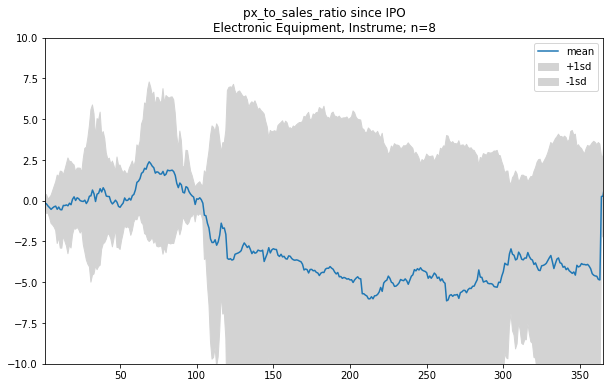

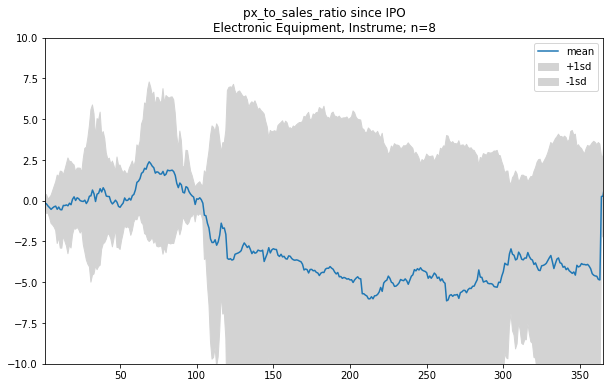

In [185]:
plot_change_since_ipo(field='px_to_sales_ratio', 
    sector='Electronic Equipment, Instrume', ylim=(-10, 10), 
    listing_year=list(range(2007, 2022)))

In [226]:
ipo_px_chg = get_change_since_ipo(field='px_last', sector='all', listing_year=list(range(20010, 2022)))
ipo_px_chg.columns = ipo_px_chg.columns.map(dict(desc.loc[:, ['Code', 'eqy_init_po_dt']].values))
ipo_px_chg = ipo_px_chg.T.sort_index()
ipo_px_chg.loc[:, "year"] = ipo_px_chg.index.to_series().apply(lambda d: d.year)
ipo_px_chg.loc[:, "quarter"] = ipo_px_chg.index.to_series().apply(lambda d: d.month // 3)
ipo_px_chg.loc[:, "month"] = ipo_px_chg.index.to_series().apply(lambda d: d.month)
ipo_px_chg.loc[:, "week"] = ipo_px_chg.index.to_series().apply(lambda d: d.day // 7)

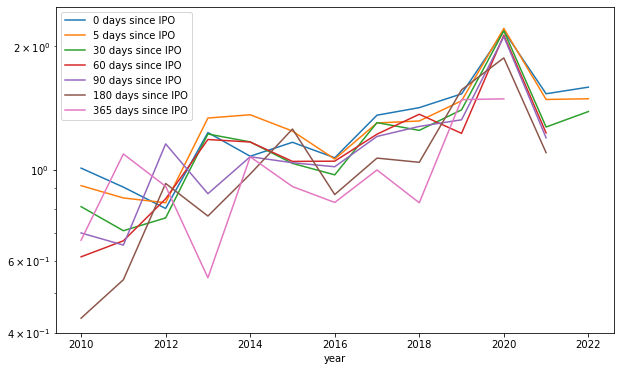

In [240]:
f, ax = plt.subplots(1, figsize=(10, 8))
plotdata = ipo_px_chg.groupby(['year']).mean().query("year>=2010")
for day_since_ipo in (0, 5, 30, 60, 90, 180, 365):
    plotdata.iloc[:, day_since_ipo].plot(kind='line',
        figsize=(10, 6), ax=ax, ylim=(0.4, 2.5), label=f"{day_since_ipo} days since IPO")
ax.set(yscale='log')
ax.legend()

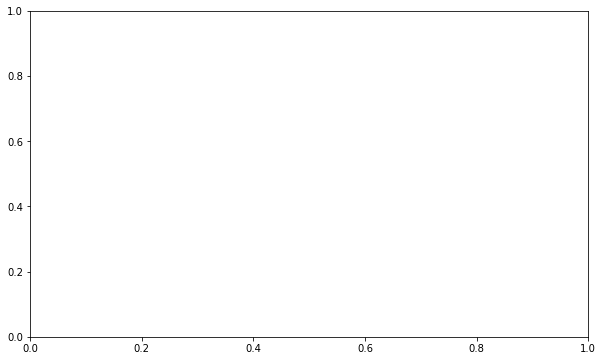

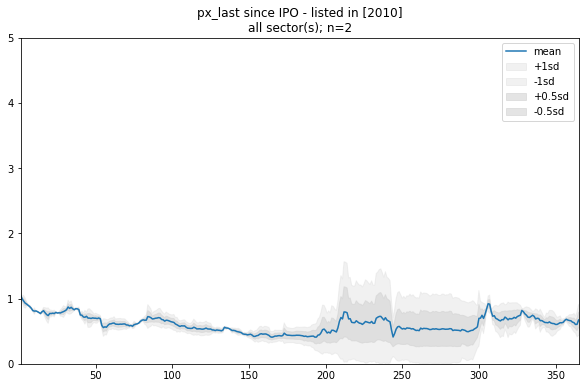

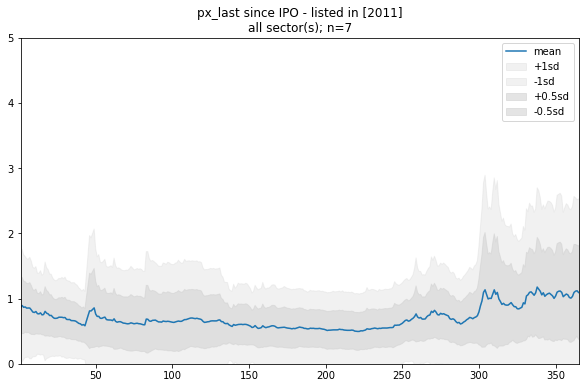

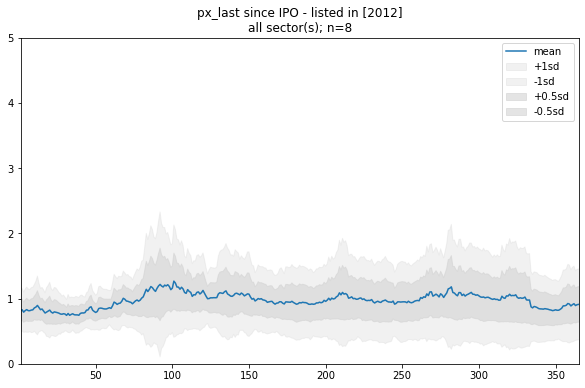

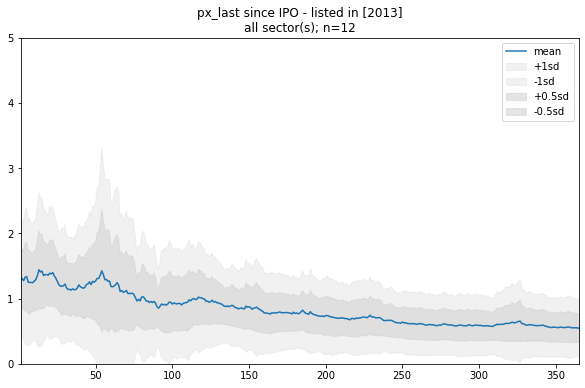

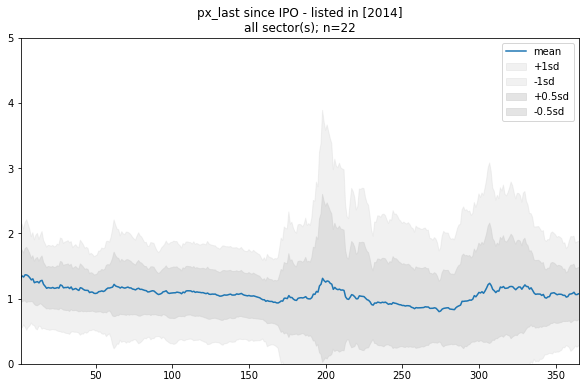

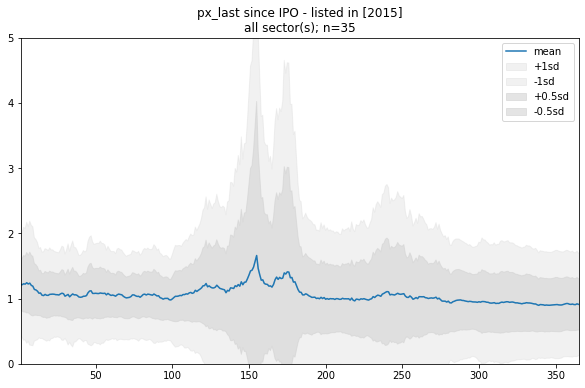

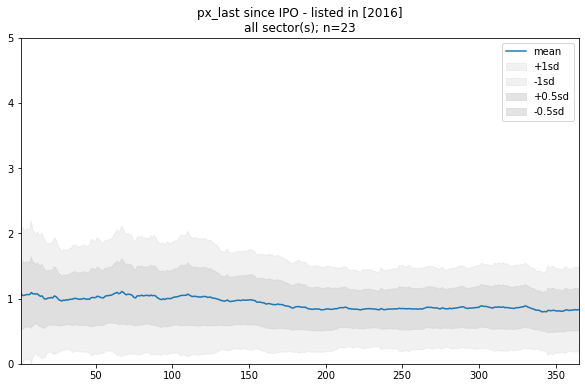

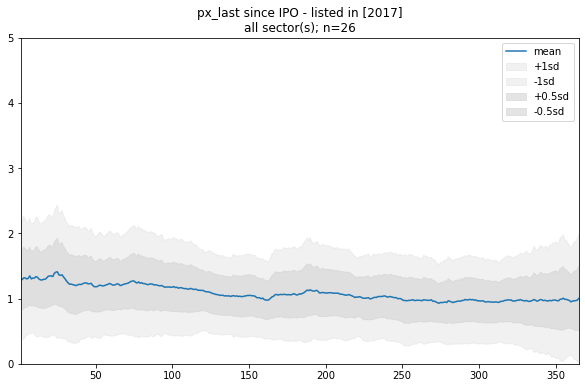

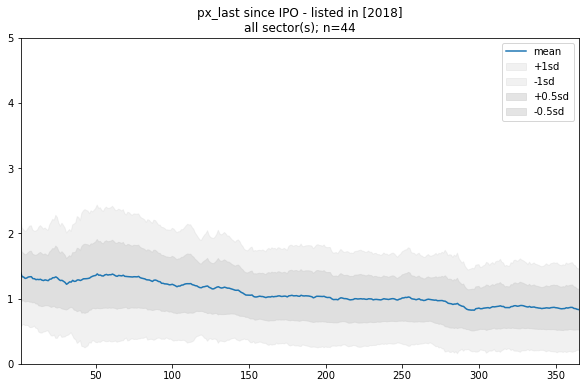

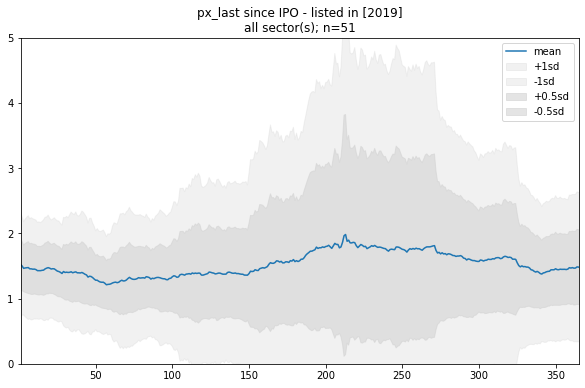

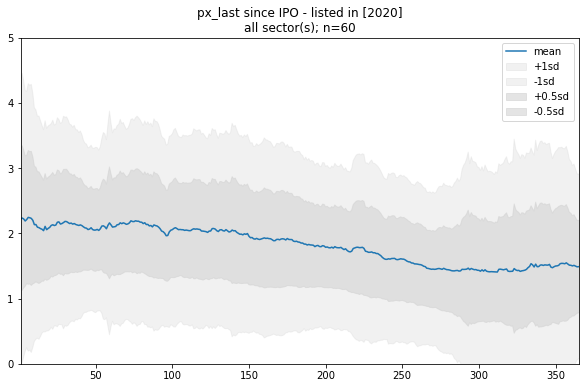

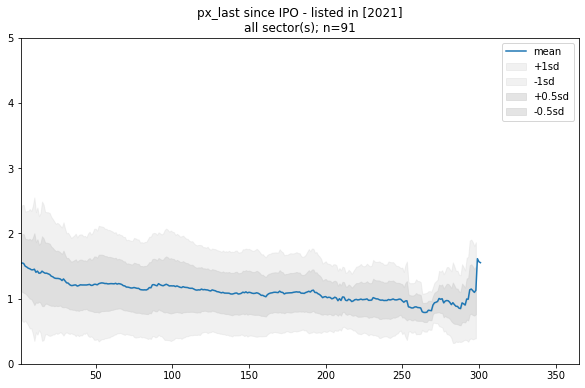

In [204]:
f, ax = plt.subplots(1, figsize=(10, 6))
for year in range(2010, 2022):
    ax = plot_change_since_ipo(field='px_last', sector='all', ylim=(0, 5), listing_year=[year])

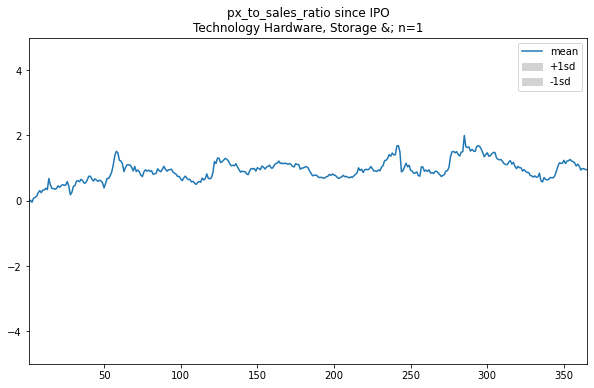

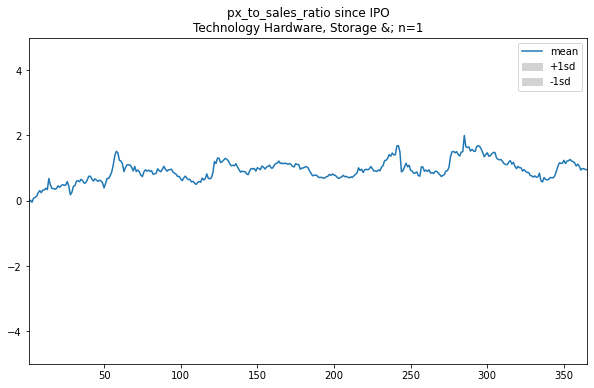

In [119]:
plot_change_since_ipo(field='px_to_sales_ratio', sector='Technology Hardware, Storage &', ylim=(-5, 5))

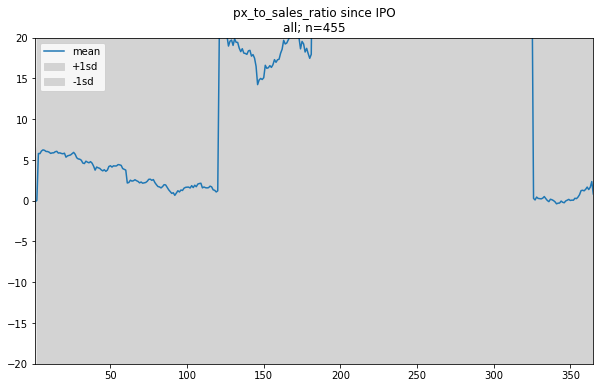

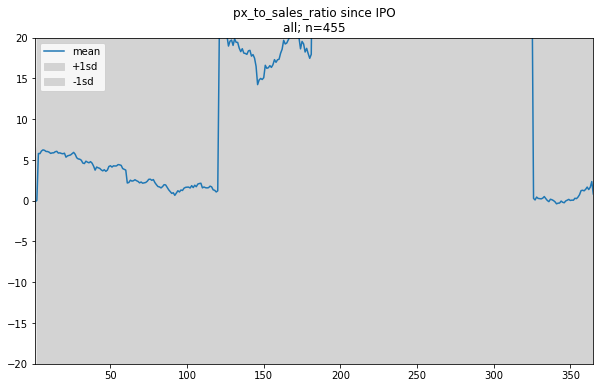

In [123]:
plot_change_since_ipo(field='px_to_sales_ratio', sector='all', ylim=(-20, 20))

In [68]:
px_since_ipo

,1400 JP Equity,1401 JP Equity,1431 JP Equity,1436 JP Equity,1739 JP Equity,2150 JP Equity,2158 JP Equity,2160 JP Equity,2164 JP Equity,2173 JP Equity,...,9254 JP Equity,9256 JP Equity,9258 JP Equity,9259 JP Equity,9270 JP Equity,9271 JP Equity,9272 JP Equity,9326 JP Equity,9467 JP Equity,9522 JP Equity
0,0.2789,0.3649,0.2482,0.7741,0.0720,0.9949,3.7220,72.5192,0.1870,0.2450,...,5.0812,2.1929,3.7212,1.2546,1.1408,0.8001,4.5147,0.8225,3.3808,2.2317
1,0.2892,0.3518,0.2648,0.7741,0.0843,0.9934,3.7955,87.2689,0.1870,0.2436,...,4.3395,2.2753,4.0357,1.2523,1.0893,0.8896,4.7179,0.8212,3.3142,2.1635
2,0.2868,0.3752,0.2648,0.7650,0.0793,1.0270,3.9730,79.8940,0.1905,0.2450,...,3.6469,2.2380,4.0383,1.1932,1.1040,0.8037,4.9436,0.8165,3.3193,2.1354
3,0.2820,0.3987,0.2648,0.7511,0.0769,1.0912,3.9302,88.4980,0.1932,0.2508,...,3.4275,2.1477,3.5378,1.3021,1.0875,0.7755,5.2296,0.8043,3.6198,1.9537
4,0.2979,0.4034,0.2648,0.7477,0.0752,1.0392,3.8506,91.5709,0.1925,0.2530,...,3.4373,2.1540,3.3832,1.2884,1.1114,0.7669,4.9812,0.7911,4.0552,1.8076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,0.6560,NaN,NaN,NaN,NaN,4.4404,5.2922,4.3931,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2274,0.6560,NaN,NaN,NaN,NaN,4.4299,5.5275,4.4115,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2275,0.6458,NaN,NaN,NaN,NaN,NaN,5.2956,4.2640,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,0.6407,NaN,NaN,NaN,NaN,NaN,5.1226,4.2419,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
desc.loc[:, ['Code', 'eqy_init_po_sh_px']]

,Code,eqy_init_po_sh_px
0,1400 JP Equity,300000.0
1,1401 JP Equity,80000.0
2,1431 JP Equity,800.0
3,1436 JP Equity,1890.0
4,1739 JP Equity,500000.0
...,...,...
450,9271 JP Equity,1700.0
451,9272 JP Equity,1350.0
452,9326 JP Equity,490.0
453,9467 JP Equity,2200.0
